# Necessary

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Gerekli kütüphaneler
!pip install fitter -q
!pip install catboost -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import * 
from sklearn.feature_selection import *
from math import sqrt
from sklearn.preprocessing import *
from pylab import rcParams
rcParams['figure.figsize'] = 25, 10
from fitter import Fitter
from statsmodels.api import OLS
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import * 
from sklearn.feature_selection import RFECV

def distrib_fit(X):
    f = Fitter(X, distributions=["norm", "expon", "uniform"])
    f.fit()
    # may take some time since by default, all distributions are tried
    # but you call manually provide a smaller set of distributions
    f.summary()

# Veri yüklemesi
train_org = pd.read_csv('/content/drive/My Drive/ODTU/data/train.csv')
submission = pd.read_csv('/content/drive/My Drive/ODTU/data/submission.csv')
train = train_org.copy()

# Müşteri ID leri model için önemli olmamalı.
#train.drop('CUSTOMER', axis=1, inplace=True)

Mounted at /content/drive


# Outlier point

In [ ]:
# Belirgin bir ayrık veri noktası var.
train[train['ISLEM_ADEDI'] == 0]

,ISLEM_TUTARI,ISLEM_ADEDI,ISLEM_TURU,YIL_AY,SEKTOR
460929,0.0,0.0,PESIN,201803,TURIZM / KONAKLAMA


In [ ]:
# Benzer bir durum submission dosyasında görünmüyor.
submission[submission['ISLEM_ADEDI'] == 0]

,ISLEM_ADEDI,ISLEM_TURU,YIL_AY,SEKTOR,CUSTOMER


In [ ]:
# Bu nokta silinebilir.
train = train[train['ISLEM_ADEDI'] != 0]

# EDA

In [ ]:
train.corr("pearson")

,ISLEM_TUTARI,ISLEM_ADEDI,YIL_AY
ISLEM_TUTARI,1.000000,0.165741,0.006658
ISLEM_ADEDI,0.165741,1.000000,0.011605
YIL_AY,0.006658,0.011605,1.000000


In [ ]:
# ISLEM_TUTARI ile ISLEM_ADEDI arasında güçlü bir ilişki olabilir, bir değişken dönüşümü gerekiyor.
train.corr("spearman")

,ISLEM_TUTARI,ISLEM_ADEDI,YIL_AY
ISLEM_TUTARI,1.000000,0.533556,0.045821
ISLEM_ADEDI,0.533556,1.000000,0.014402
YIL_AY,0.045821,0.014402,1.000000


### ISLEM_TUTARI İnceleme

In [ ]:
train['ISLEM_TUTARI'].describe()

count    1.765523e+06
mean     3.863139e+02
std      1.933918e+03
min      1.000000e-02
25%      5.400000e+01
50%      1.349800e+02
75%      3.171400e+02
max      3.205612e+05
Name: ISLEM_TUTARI, dtype: float64

In [ ]:
train['ISLEM_TUTARI'].skew()

55.41403845781313

Fitted norm distribution with error=1.931487298171584e-08)
Fitted expon distribution with error=7.120148665243603e-08)
Fitted uniform distribution with error=9.369397607989846e-08)


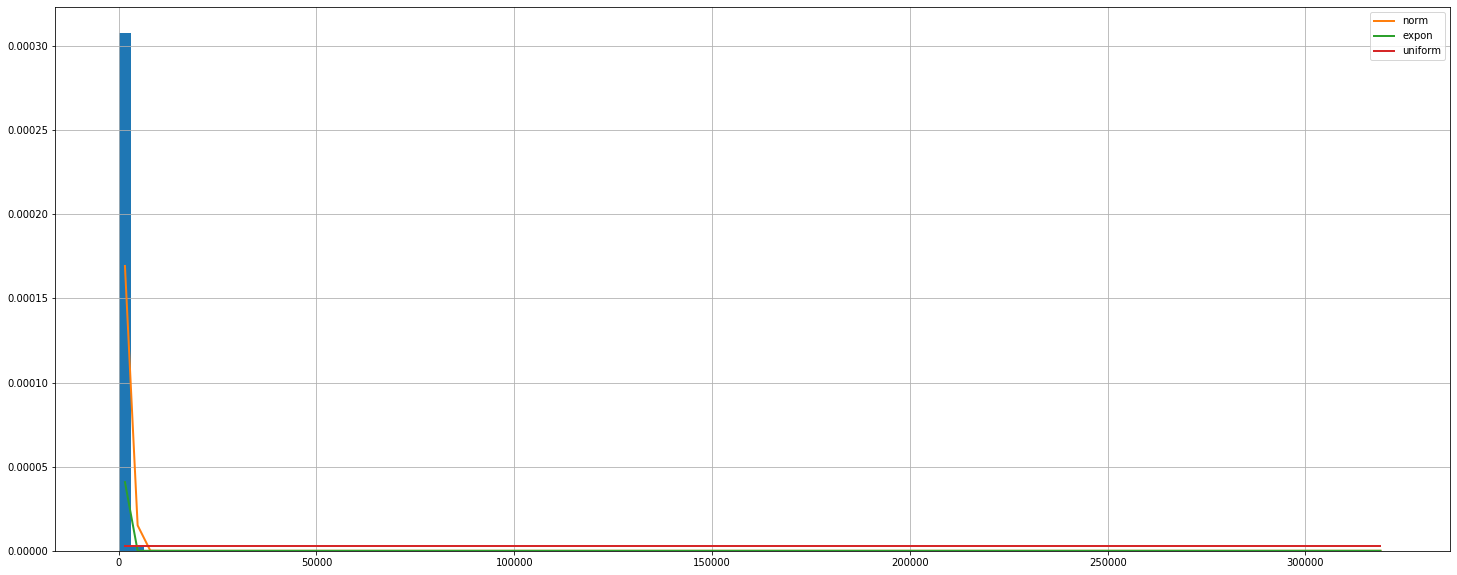

In [ ]:
# ISLEM_TUTARI belirgin bir sağa çarpık dağılım gösteriyor. Dönüşüm gerekli. 
# (Normal dağılıma sahip bir bağımlı değişkeni tahminlemeye çalışmak daha sağlıklı bir model yaratır.)
distrib_fit(train['ISLEM_TUTARI'])

In [ ]:
# ISLEM_TUTARI Normalleştirme için yeo-johnson güç dönüşümü
pt = PowerTransformer(method='yeo-johnson')
train['ISLEM_TUTARI'] = pt.fit_transform(train.ISLEM_TUTARI.values.reshape(-1,1))

Fitted norm distribution with error=0.0484722931700453)
Fitted expon distribution with error=2.463868711870723)
Fitted uniform distribution with error=1.9583332709312966)


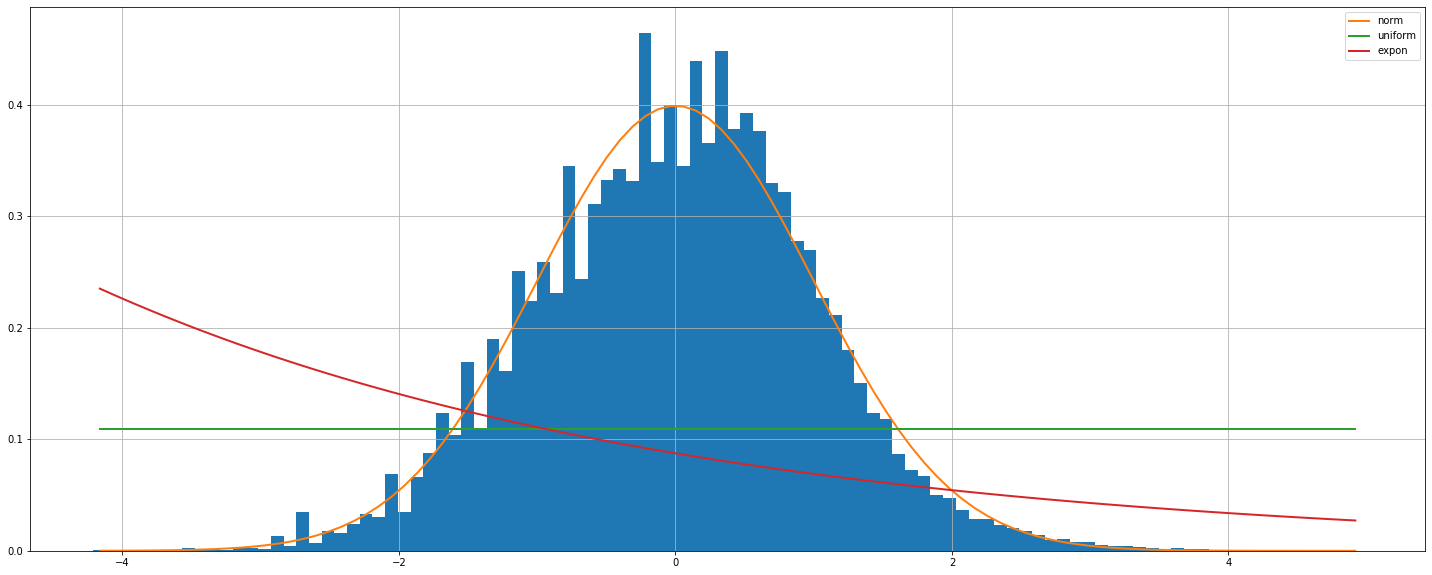

In [ ]:
# Normale büyük ölçüde yakınsayan bir dağılım elde ettik.
distrib_fit(train['ISLEM_TUTARI'])

### 'ISLEM_ADEDI' İnceleme

In [ ]:
train['ISLEM_ADEDI'].describe()

count    1.765523e+06
mean     3.087947e+00
std      4.449754e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      7.160000e+02
Name: ISLEM_ADEDI, dtype: float64

In [ ]:
train['ISLEM_ADEDI'].skew()

14.606056153344234

Fitted norm distribution with error=0.002089649118289101)
Fitted expon distribution with error=0.0019122152175603175)
Fitted uniform distribution with error=0.01673798701167149)


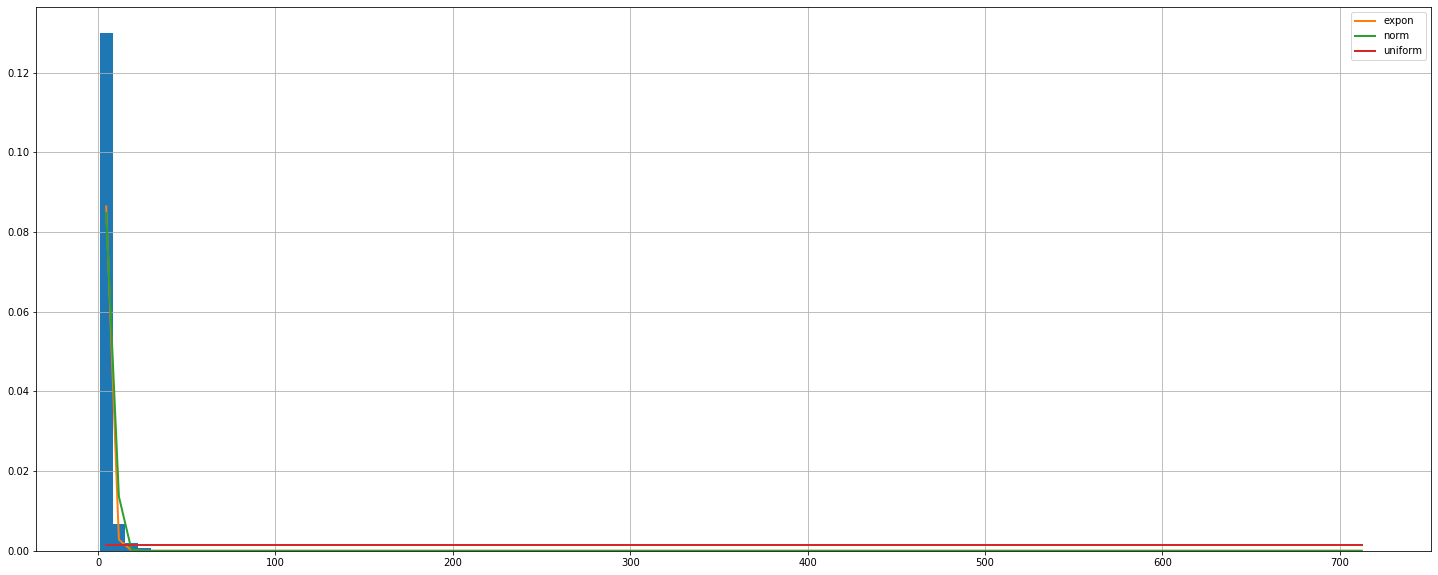

In [ ]:
# ISLEM_ADEDI belirgin bir sağa çarpık dağılım gösteriyor. Dönüşüm gerekli.
distrib_fit(train['ISLEM_ADEDI'])

In [ ]:
train['ISLEM_ADEDI'] = np.log(train.ISLEM_ADEDI.values.reshape(-1,1))

Fitted norm distribution with error=59.40693471859116)
Fitted expon distribution with error=51.47299198634179)
Fitted uniform distribution with error=63.029126940984305)


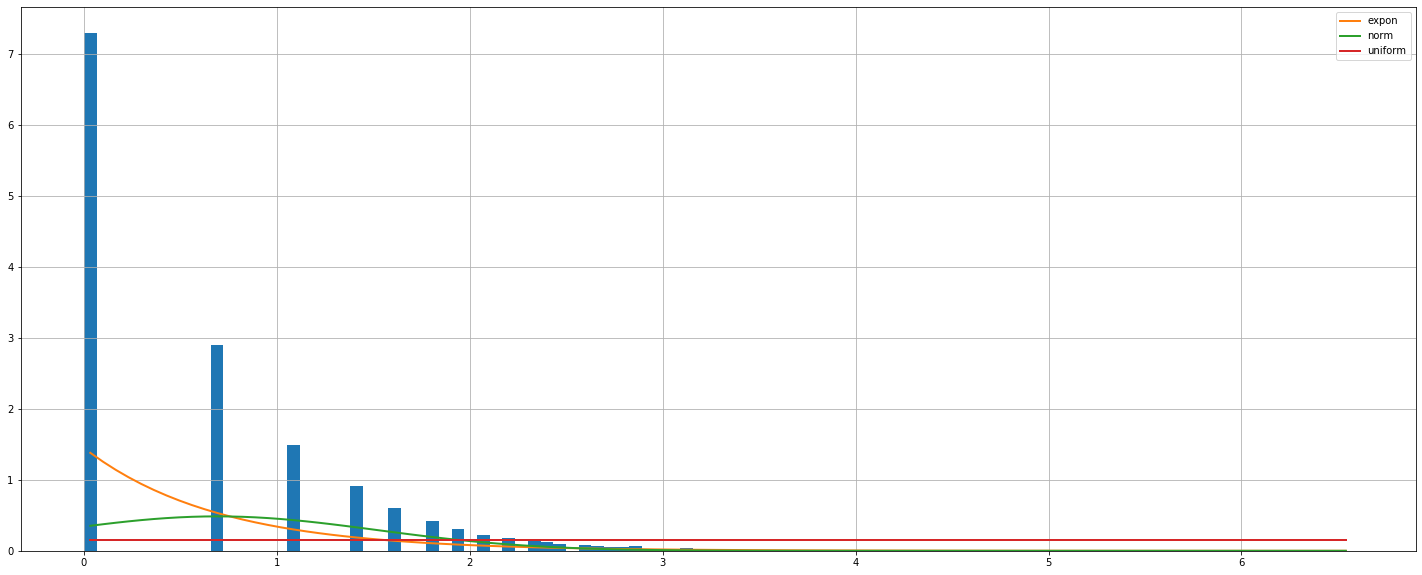

In [ ]:
# ISLEM_ADEDI belirgin bir sağa çarpık dağılım gösteriyor. Dönüşüm gerekli.
distrib_fit(train['ISLEM_ADEDI'])

### ISLEM_TUTARI vs. ISLEM_ADEDI

In [ ]:
pearsonr(train['ISLEM_TUTARI'], train['ISLEM_ADEDI'])

(0.5140758194302584, 0.0)

In [ ]:
spearmanr(train['ISLEM_TUTARI'], train['ISLEM_ADEDI'])

SpearmanrResult(correlation=0.5335557184067014, pvalue=0.0)

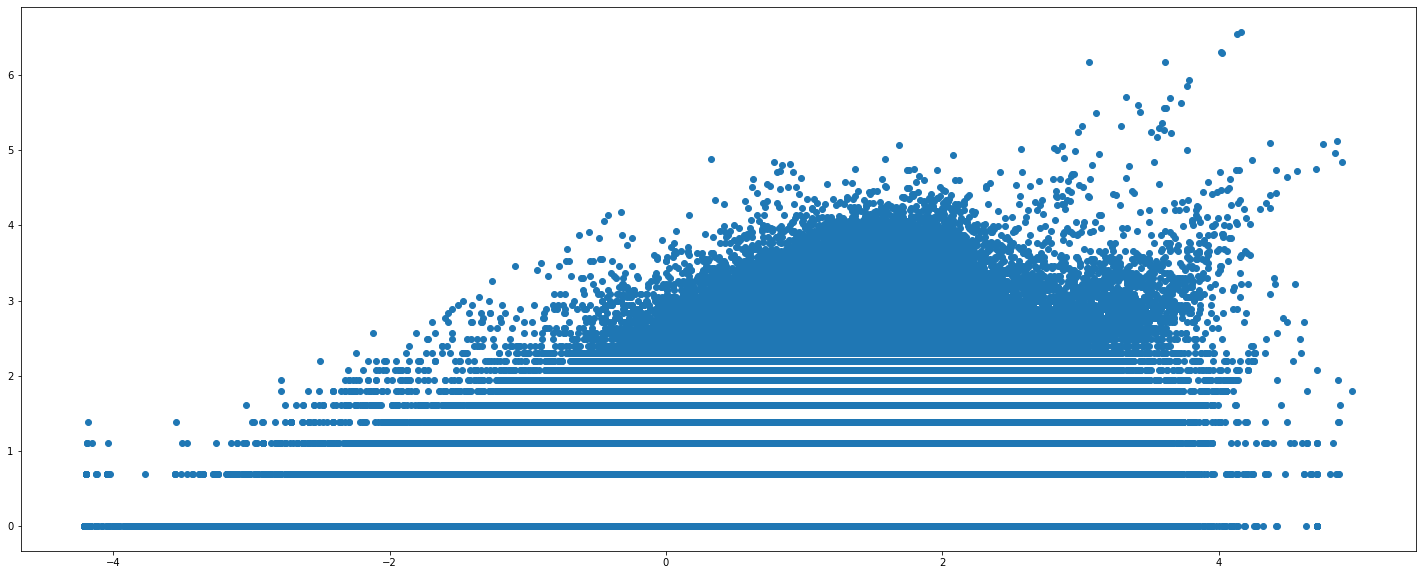

In [ ]:
# aradaki kuvvetli ilişki pozitif bölgede daha iyi gözlemlenebiliyor.
plt.scatter(train['ISLEM_TUTARI'], train['ISLEM_ADEDI'])

# Model

### Preparing data for model training

In [ ]:
seed = 13
data=train.sample(frac=0.8, random_state=seed) #random state is a seed value
test=train.drop(data.index)

# Extract feature columns
feature_cols = ['ISLEM_ADEDI', 'ISLEM_TURU', 'SEKTOR']

# Extract target column 'type'
target_col = ['ISLEM_TUTARI']

# Show the list of columns
print("Feature columns:\n{}".format(feature_cols))
print("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = data[feature_cols]
y_all = data[target_col]

# Show the feature information by printing the first five rows
print("\nFeature values:")
print(X_all.head())

# Extract feature columns
feature_cols = list(test.columns)

# Show the list of columns
print("Feature columns:\n{}".format(feature_cols))
print("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all_test = test[feature_cols]
y_all_test = test[target_col]

# Show the feature information by printing the first five rows
print("\nFeature values test:")
print(X_all_test.head())


def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.items():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print("\nProcessed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

X_all_test = preprocess_features(X_all_test)
print("\nProcessed feature columns test ({} total features):\n{}".format(len(X_all_test.columns), list(X_all_test.columns)))

# remove constant features
constant_features = [
    feat for feat in X_all.columns if X_all[feat].std() == 0
]

X_all.drop(labels=constant_features, axis=1, inplace=True)
X_all_test.drop(labels=constant_features, axis=1, inplace=True)

X_all.shape, X_all_test.shape

# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_all.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_all.columns[i]

    for col_2 in X_all.columns[i + 1:]:
        if X_all[col_1].equals(X_all[col_2]):
            duplicated_feat.append(col_2)
            
# remove duplicated features
X_all.drop(labels=duplicated_feat, axis=1, inplace=True)
X_all_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_all.shape, X_all_test.shape


# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_all, 0.8)
print('correlated features: ', len(set(corr_features)) )

# removed correlated  features
X_all.drop(labels=corr_features, axis=1, inplace=True)
X_all_test.drop(labels=corr_features, axis=1, inplace=True)

X_all.shape, X_all_test.shape
X_all_test = X_all_test[X_all.columns]

# remove quasi-constant features
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit_transform(X_all)  # fit finds the features with low variance
sel.fit_transform(X_all_test)

features_to_keep = X_all.columns[sel.get_support()]

X_all.shape, X_all_test.shape

X_all = pd.DataFrame(X_all[features_to_keep])
X_all.columns = features_to_keep

X_all_test = pd.DataFrame(X_all_test[features_to_keep])
X_all_test.columns = features_to_keep

X_all.rename(columns={"ISLEM_TURU_PESIN": "ISLEM_TURU_PESIN"}, inplace=True)
X_all_test.rename(columns={"ISLEM_TURU_PESIN": "ISLEM_TURU_PESIN"}, inplace=True)

Feature columns:
['ISLEM_ADEDI', 'ISLEM_TURU', 'SEKTOR']

Target column: ['ISLEM_TUTARI']

Feature values:
         ISLEM_ADEDI ISLEM_TURU                         SEKTOR
646908      1.098612      PESIN               GIYIM / AKSESUAR
560385      1.609438      PESIN               GIYIM / AKSESUAR
1416052     2.833213      PESIN  MARKET / ALISVERIS MERKEZLERI
1472574     0.693147      PESIN   BENZIN VE YAKIT ISTASYONLARI
797343      0.000000      PESIN               GIYIM / AKSESUAR
Feature columns:
['ISLEM_TUTARI', 'ISLEM_ADEDI', 'ISLEM_TURU', 'YIL_AY', 'SEKTOR', 'CUSTOMER']

Target column: ['ISLEM_TUTARI']

Feature values test:
    ISLEM_TUTARI  ISLEM_ADEDI  ...                         SEKTOR  CUSTOMER
0       1.068623     0.693147  ...             BIREYSEL EMEKLILIK       219
14      0.004361     2.708050  ...                   CESITLI GIDA       219
15     -0.231831     0.693147  ...          EGLENCE / SPOR / HOBI       219
16     -1.526983     0.693147  ...  MARKET / ALISVERIS MERKEZ

# Baseline Modeli

### Fitting Linear Regression Model & Checking Linear Regression Assumptions 

Fitting linear regression

Coefficients
-------------------------------------
Intercept: [-0.45390342]
X1: [ 0.          0.74603954 -0.05363305]

Performing linear regression assumption testing

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


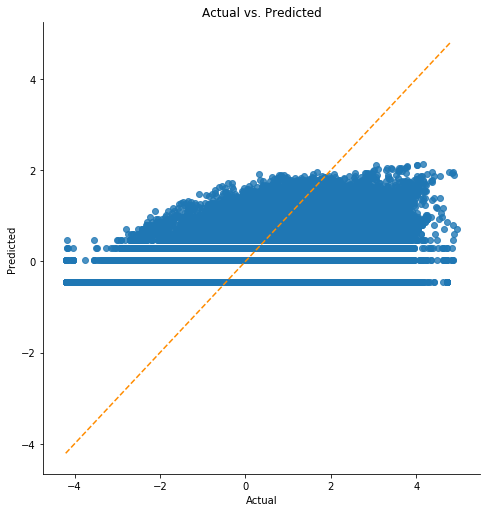

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


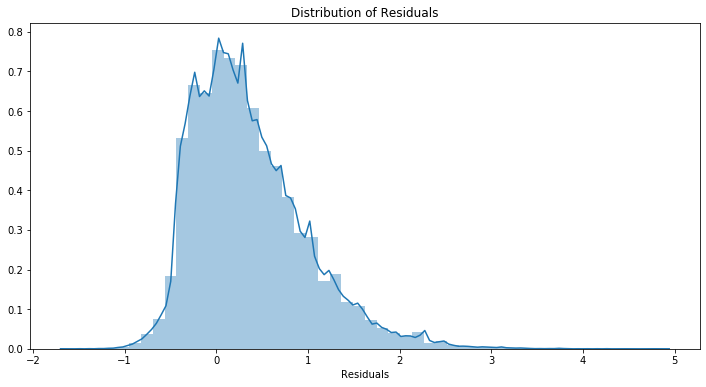


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables

Assumption 3: Little to no multicollinearity among predictors


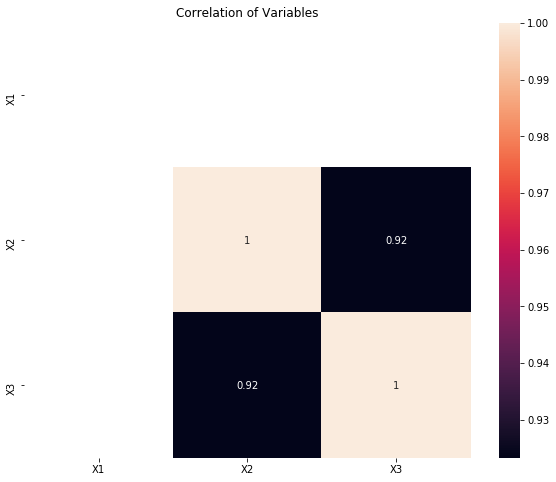

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
X1: 1.9855744426264907
X2: 6.7787182957125065
X3: 6.778718295708364

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied

Assumption 4: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.4932452351722068
Signs of positive autocorrelation 

Assumption not satisfied 

Consider adding lag variables

Assumption 5: Homoscedasticity of Error Terms
Residuals should have relative constant variance


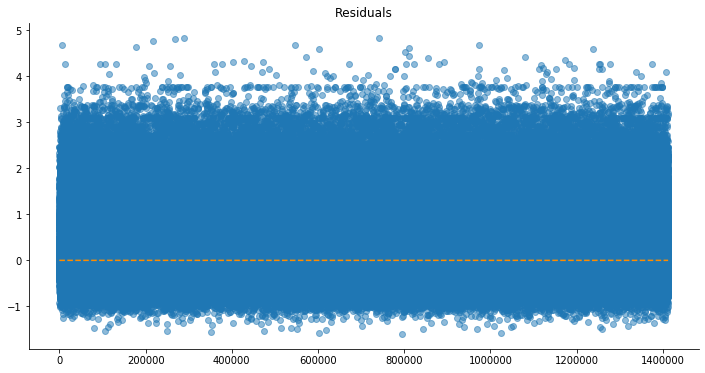

If heteroscedasticity is apparent, confidence intervals and predictions will be affected

R^2: 0.2659297943922133 

RMSE: 1949.9088703759762 



In [ ]:
# Baseline modeli sadece "ISLEM_ADEDI" özniteliği kullanılarak oluşturulan naif bir Lineer Regresyon Modeli olabilir.

X_all_copy = X_all.drop(X_all.columns[1:], axis=1)

def linear_regression_assumptions(features, label, feature_names=None):
    """
    Tests a linear regression on the model to see if assumptions are being met
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=2)
    features = poly.fit_transform(features)
    
    # Setting feature names to x1, x2, x3, etc. if they are not defined
    if feature_names is None:
        feature_names = ['X'+str(feature+1) for feature in range(features.shape[1])]
    
    print('Fitting linear regression')
    # Multi-threading if the dataset is a size where doing so is beneficial
    if features.shape[0] < 100000:
        model = LinearRegression(n_jobs=-1)
    else:
        model = LinearRegression()
        
    model.fit(features, label)
    
    # Returning linear regression R^2 and coefficients before performing diagnostics
    r2 = model.score(features, label)
    y_pred_test = model.predict(features)
    rmse = sqrt(mean_squared_error(pt.inverse_transform(label), pt.inverse_transform(y_pred_test)))
    print()
    print('Coefficients')
    print('-------------------------------------')
    print('Intercept:', model.intercept_)
    
    for feature in range(len(model.coef_)):
        print('{0}: {1}'.format(feature_names[feature], model.coef_[feature]))

    print('\nPerforming linear regression assumption testing')
    
    # Creating predictions and calculating residuals for assumption tests
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label.flatten(), 'Predicted': predictions.flatten()})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

    
    def linear_assumption():
        """
        Linearity: Assumes there is a linear relationship between the predictors and
                   the response variable. If not, either a polynomial term or another
                   algorithm should be used.
        """
        print('\n=======================================================================================')
        print('Assumption 1: Linear Relationship between the Target and the Features')
        
        print('Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')
        
        # Plotting the actual vs predicted values
        sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7)
        
        # Plotting the diagonal line
        line_coords = np.arange(df_results.min().min(), df_results.max().max())
        plt.plot(line_coords, line_coords,  # X and y points
                 color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('If non-linearity is apparent, consider adding a polynomial term')
        
        
    def normal_errors_assumption(p_value_thresh=0.05):
        """
        Normality: Assumes that the error terms are normally distributed. If they are not,
        nonlinear transformations of variables may solve this.
               
        This assumption being violated primarily causes issues with the confidence intervals
        """
        from statsmodels.stats.diagnostic import normal_ad
        print('\n=======================================================================================')
        print('Assumption 2: The error terms are normally distributed')
        print()
    
        print('Using the Anderson-Darling test for normal distribution')

        # Performing the test on the residuals
        p_value = normal_ad(df_results['Residuals'])[1]
        print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
        # Reporting the normality of the residuals
        if p_value < p_value_thresh:
            print('Residuals are not normally distributed')
        else:
            print('Residuals are normally distributed')
    
        # Plotting the residuals distribution
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(df_results['Residuals'])
        plt.show()
    
        print()
        if p_value > p_value_thresh:
            print('Assumption satisfied')
        else:
            print('Assumption not satisfied')
            print()
            print('Confidence intervals will likely be affected')
            print('Try performing nonlinear transformations on variables')
        
        
    def multicollinearity_assumption():
        """
        Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                           correlation among the predictors, then either remove prepdictors with high
                           Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                           This assumption being violated causes issues with interpretability of the 
                           coefficients and the standard errors of the coefficients.
        """
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        print('\n=======================================================================================')
        print('Assumption 3: Little to no multicollinearity among predictors')
        
        # Plotting the heatmap
        plt.figure(figsize = (10,8))
        sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
        plt.title('Correlation of Variables')
        plt.show()
        
        print('Variance Inflation Factors (VIF)')
        print('> 10: An indication that multicollinearity may be present')
        print('> 100: Certain multicollinearity among the variables')
        print('-------------------------------------')
       
        # Gathering the VIF for each variable
        VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
        for idx, vif in enumerate(VIF):
            print('{0}: {1}'.format(feature_names[idx], vif))
        
        # Gathering and printing total cases of possible or definite multicollinearity
        possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
        definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
        print()
        print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
        print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
        print()

        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied')
            else:
                print('Assumption possibly satisfied')
                print()
                print('Coefficient interpretability may be problematic')
                print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        else:
            print('Assumption not satisfied')
            print()
            print('Coefficient interpretability will be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        
        
    def autocorrelation_assumption():
        """
        Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                         autocorrelation, then there is a pattern that is not explained due to
                         the current value being dependent on the previous value.
                         This may be resolved by adding a lag variable of either the dependent
                         variable or some of the predictors.
        """
        from statsmodels.stats.stattools import durbin_watson
        print('\n=======================================================================================')
        print('Assumption 4: No Autocorrelation')
        print('\nPerforming Durbin-Watson Test')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
        print('0 to 2< is positive autocorrelation')
        print('>2 to 4 is negative autocorrelation')
        print('-------------------------------------')
        durbinWatson = durbin_watson(df_results['Residuals'])
        print('Durbin-Watson:', durbinWatson)
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        else:
            print('Little to no autocorrelation', '\n')
            print('Assumption satisfied')

            
    def homoscedasticity_assumption():
        """
        Homoscedasticity: Assumes that the errors exhibit constant variance
        """
        print('\n=======================================================================================')
        print('Assumption 5: Homoscedasticity of Error Terms')
        print('Residuals should have relative constant variance')
        
        # Plotting the residuals
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)  # To remove spines
        plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
        plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
        ax.spines['right'].set_visible(False)  # Removing the right spine
        ax.spines['top'].set_visible(False)  # Removing the top spine
        plt.title('Residuals')
        plt.show() 
        print('If heteroscedasticity is apparent, confidence intervals and predictions will be affected')
        
    linear_assumption()
    normal_errors_assumption()
    multicollinearity_assumption()
    autocorrelation_assumption()
    homoscedasticity_assumption()
    print()
    print('R^2:', r2, '\n')
    print('RMSE:', rmse, '\n')

linear_regression_assumptions(X_all_copy.values, y_all.values)

In [ ]:
"""
Baseline model sonuçları:
    R^2: 0.2659297943922133 
    RMSE: 1949.9088703759762 
"""    

### Feature Importance w/ XGBoost

XGBoost & Bütün öz nitelikler kullanıldığında RMSE = 1700.116627


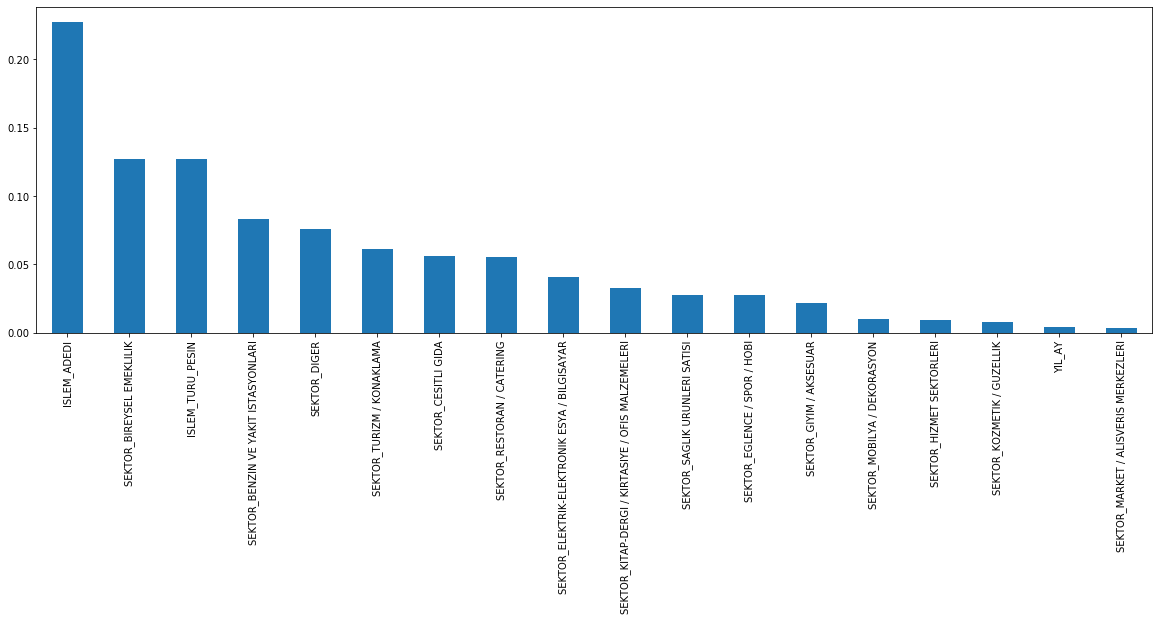

In [ ]:
# the first step of this procedure consists in building a machine learning algorithm using all the available features and then determine the importance of the features according to the algorithm.

# set the seed for reproducibility
seed_val = 0
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1)

# Split data
model_all_features.fit(X_all, y_all)

# calculate the RMSE in the test set
y_pred_test = model_all_features.predict(X_all_test)
rmse = sqrt(mean_squared_error(pt.inverse_transform(y_all_test.values.reshape(-1,1)), pt.inverse_transform(y_pred_test.reshape(-1,1))))
print('XGBoost & Bütün öz nitelikler kullanıldığında RMSE = %f' % (rmse))

# the second step consist of deriving the importance of each feature and ranking them from the least to the most important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_all.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(20,6))
features = list(features.index)

### Recursive Feature Elimination

Optimal number of features : 17


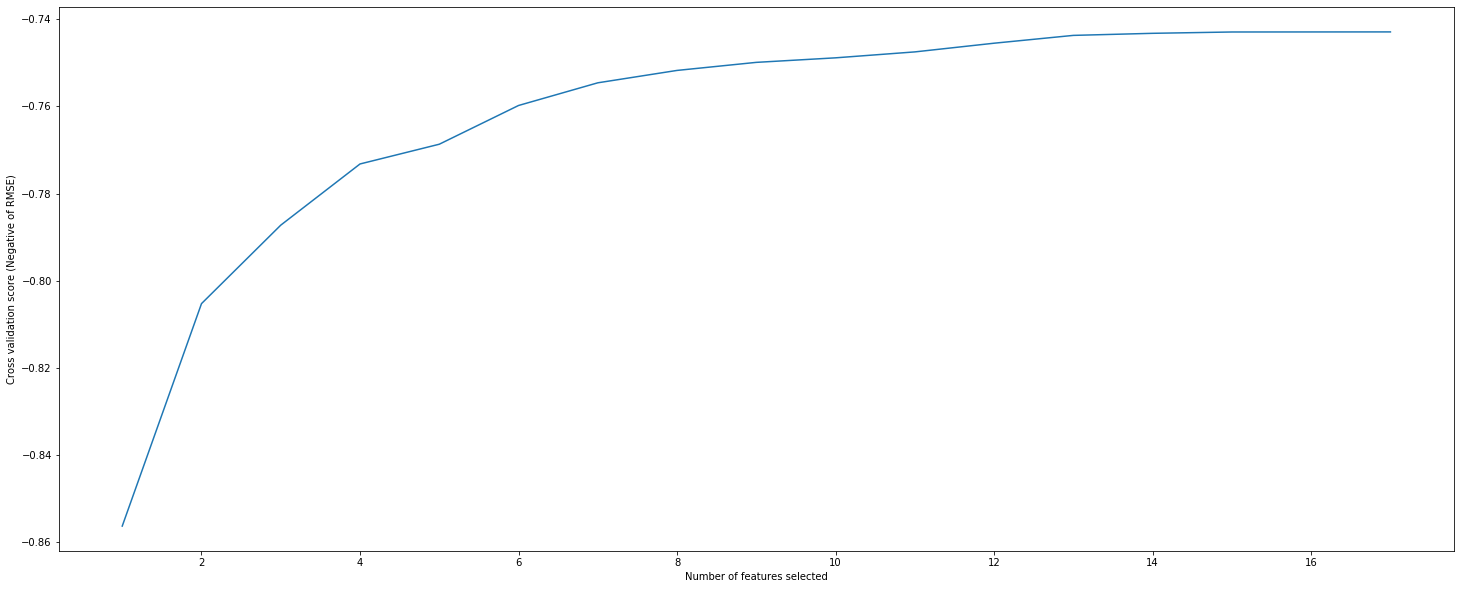

In [ ]:
# Recursive Feature Elimination ile modele girecek öz nitelikler tespit edilir.

rfecv = RFECV(estimator=xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1, **{'tree_method' : 'gpu_hist', 'n_gpus' : 1}),
              step = 1,
              cv = 5, 
              scoring='neg_root_mean_squared_error',
              n_jobs = -1)
rfecv.fit(X_all, y_all.values.ravel())

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (Negative of RMSE)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
# Model için kullanılabilecek öz nitelikler
model_final_features = []
for i, col in enumerate(X_all.columns):
    if rfecv.support_[i]:
        print(col)
        model_final_features.append(col)

ISLEM_ADEDI
ISLEM_TURU_PESIN
SEKTOR_BENZIN VE YAKIT ISTASYONLARI
SEKTOR_BIREYSEL EMEKLILIK
SEKTOR_CESITLI GIDA
SEKTOR_DIGER
SEKTOR_EGLENCE / SPOR / HOBI
SEKTOR_ELEKTRIK-ELEKTRONIK ESYA / BILGISAYAR
SEKTOR_GIYIM / AKSESUAR
SEKTOR_HIZMET SEKTORLERI
SEKTOR_KITAP-DERGI / KIRTASIYE / OFIS MALZEMELERI
SEKTOR_KOZMETIK / GUZELLIK
SEKTOR_MARKET / ALISVERIS MERKEZLERI
SEKTOR_MOBILYA / DEKORASYON
SEKTOR_RESTORAN / CATERING
SEKTOR_SAGLIK URUNLERI SATISI
SEKTOR_TURIZM / KONAKLAMA


### Cross Val Routine

In [ ]:
from sklearn.model_selection import *
import xgboost as xgb

# xgb.XGBRegressor(objective ='reg:squarederror', max_depth=4, n_estimators=600, learning_rate=0.05, n_jobs=-1, **{'tree_method' : 'gpu_hist', 'n_gpus' : 1})

scores = cross_validate(xgb.XGBRegressor(objective ='reg:squarederror', max_depth=4, n_estimators=600, learning_rate=0.05, n_jobs=-1, **{'tree_method' : 'gpu_hist', 'n_gpus' : 1}),
                        X_all[model_final_features], y_all.values.reshape(-1,1), cv=5,
                        scoring=('neg_root_mean_squared_error'),
                        return_train_score=True,
                        return_estimator=True
                        )

rmse_scores = []

for est in scores['estimator']:
    # calculate the RMSE in the test set
    y_pred_test = est.predict(X_all_test[model_final_features])
    rmse_scores.append(sqrt(mean_squared_error(pt.inverse_transform(y_all_test.values.reshape(-1,1)), pt.inverse_transform(y_pred_test.reshape(-1,1)))))
    

print('XGBoost & Seçilen öz nitelikler kullanıldığında Validasyon Ortalama RMSE = %f' % (np.mean(rmse_scores)))
print('XGBoost & Seçilen öz nitelikler kullanıldığında Validasyon Standart Sapma RMSE = %f' % (np.std(rmse_scores)))

XGBoost & Seçilen öz nitelikler kullanıldığında Validasyon Ortalama RMSE = 1680.648937
XGBoost & Seçilen öz nitelikler kullanıldığında Validasyon Standart Sapma RMSE = 1.619101


Fitting linear regression

Performing linear regression assumption testing

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


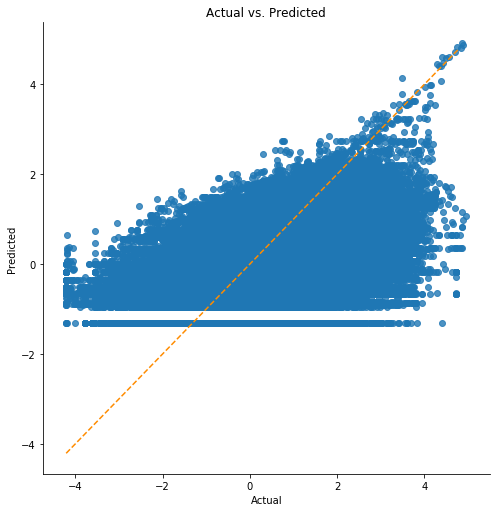

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


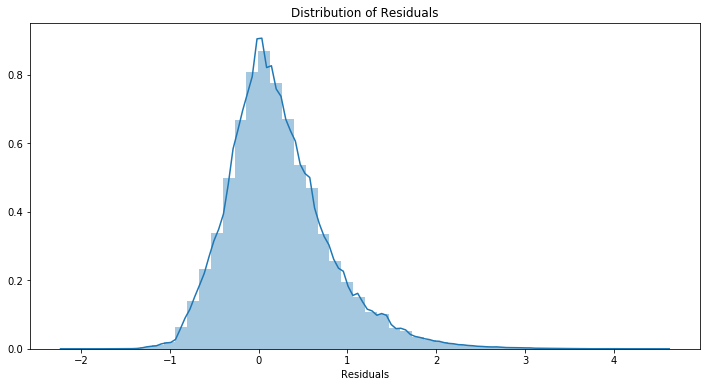


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables

Assumption 4: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.7344470027023549
Little to no autocorrelation 

Assumption satisfied

Assumption 5: Homoscedasticity of Error Terms
Residuals should have relative constant variance


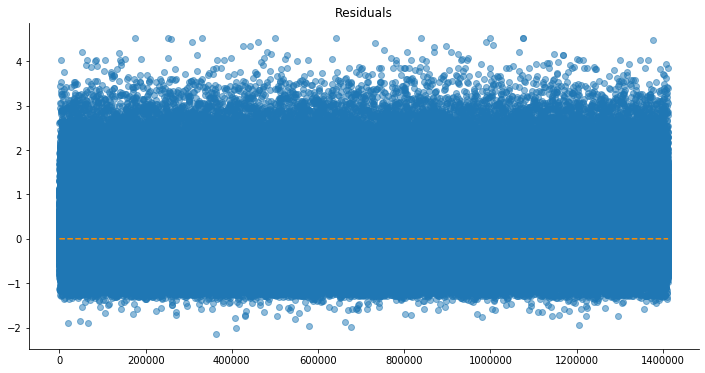

If heteroscedasticity is apparent, confidence intervals and predictions will be affected

R^2: 0.45130091379081433 

RMSE: 1880.9235237036896 



In [ ]:
# Baseline modeli sadece "ISLEM_ADEDI" özniteliği kullanılarak oluşturulan naif bir Lineer Regresyon Modeli olabilir.

def regression_assumptions(features, label, model):
    """
    Tests a linear regression on the model to see if assumptions are being met
    """
    feature_names=None
    # Setting feature names to x1, x2, x3, etc. if they are not defined
    if feature_names is None:
        feature_names = ['X'+str(feature+1) for feature in range(features.shape[1])]
    
    print('Fitting linear regression')
    # Multi-threading if the dataset is a size where doing so is beneficial
    #model = xgb.XGBRegressor(objective ='reg:squarederror', max_depth=4, n_estimators=600, learning_rate=0.05, n_jobs=-1, **{'tree_method' : 'gpu_hist', 'n_gpus' : 1})
    #model.fit(features, label)
    
    # Returning linear regression R^2 and coefficients before performing diagnostics
    r2 = model.score(features, label)
    y_pred_test = model.predict(features)
    rmse = sqrt(mean_squared_error(pt.inverse_transform(label.reshape(-1, 1)), pt.inverse_transform(y_pred_test.reshape(-1, 1))))
    #print()
    #print('Coefficients')
    #print('-------------------------------------')
    #print('Intercept:', model.intercept_)
    
    #for feature in range(len(model.coef_)):
        #print('{0}: {1}'.format(feature_names[feature], model.coef_[feature]))

    print('\nPerforming linear regression assumption testing')
    
    # Creating predictions and calculating residuals for assumption tests
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label.flatten(), 'Predicted': predictions.flatten()})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

    
    def linear_assumption():
        """
        Linearity: Assumes there is a linear relationship between the predictors and
                   the response variable. If not, either a polynomial term or another
                   algorithm should be used.
        """
        print('\n=======================================================================================')
        print('Assumption 1: Linear Relationship between the Target and the Features')
        
        print('Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')
        
        # Plotting the actual vs predicted values
        sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7)
        
        # Plotting the diagonal line
        line_coords = np.arange(df_results.min().min(), df_results.max().max())
        plt.plot(line_coords, line_coords,  # X and y points
                 color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('If non-linearity is apparent, consider adding a polynomial term')
        
        
    def normal_errors_assumption(p_value_thresh=0.05):
        """
        Normality: Assumes that the error terms are normally distributed. If they are not,
        nonlinear transformations of variables may solve this.
               
        This assumption being violated primarily causes issues with the confidence intervals
        """
        from statsmodels.stats.diagnostic import normal_ad
        print('\n=======================================================================================')
        print('Assumption 2: The error terms are normally distributed')
        print()
    
        print('Using the Anderson-Darling test for normal distribution')

        # Performing the test on the residuals
        p_value = normal_ad(df_results['Residuals'])[1]
        print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
        # Reporting the normality of the residuals
        if p_value < p_value_thresh:
            print('Residuals are not normally distributed')
        else:
            print('Residuals are normally distributed')
    
        # Plotting the residuals distribution
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(df_results['Residuals'])
        plt.show()
    
        print()
        if p_value > p_value_thresh:
            print('Assumption satisfied')
        else:
            print('Assumption not satisfied')
            print()
            print('Confidence intervals will likely be affected')
            print('Try performing nonlinear transformations on variables')
        
        
    def multicollinearity_assumption():
        """
        Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                           correlation among the predictors, then either remove prepdictors with high
                           Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                           This assumption being violated causes issues with interpretability of the 
                           coefficients and the standard errors of the coefficients.
        """
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        print('\n=======================================================================================')
        print('Assumption 3: Little to no multicollinearity among predictors')
        
        # Plotting the heatmap
        plt.figure(figsize = (10,8))
        sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
        plt.title('Correlation of Variables')
        plt.show()
        
        print('Variance Inflation Factors (VIF)')
        print('> 10: An indication that multicollinearity may be present')
        print('> 100: Certain multicollinearity among the variables')
        print('-------------------------------------')
       
        # Gathering the VIF for each variable
        VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
        for idx, vif in enumerate(VIF):
            print('{0}: {1}'.format(feature_names[idx], vif))
        
        # Gathering and printing total cases of possible or definite multicollinearity
        possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
        definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
        print()
        print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
        print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
        print()

        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied')
            else:
                print('Assumption possibly satisfied')
                print()
                print('Coefficient interpretability may be problematic')
                print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        else:
            print('Assumption not satisfied')
            print()
            print('Coefficient interpretability will be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        
        
    def autocorrelation_assumption():
        """
        Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                         autocorrelation, then there is a pattern that is not explained due to
                         the current value being dependent on the previous value.
                         This may be resolved by adding a lag variable of either the dependent
                         variable or some of the predictors.
        """
        from statsmodels.stats.stattools import durbin_watson
        print('\n=======================================================================================')
        print('Assumption 4: No Autocorrelation')
        print('\nPerforming Durbin-Watson Test')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
        print('0 to 2< is positive autocorrelation')
        print('>2 to 4 is negative autocorrelation')
        print('-------------------------------------')
        durbinWatson = durbin_watson(df_results['Residuals'])
        print('Durbin-Watson:', durbinWatson)
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        else:
            print('Little to no autocorrelation', '\n')
            print('Assumption satisfied')

            
    def homoscedasticity_assumption():
        """
        Homoscedasticity: Assumes that the errors exhibit constant variance
        """
        print('\n=======================================================================================')
        print('Assumption 5: Homoscedasticity of Error Terms')
        print('Residuals should have relative constant variance')
        
        # Plotting the residuals
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)  # To remove spines
        plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
        plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
        ax.spines['right'].set_visible(False)  # Removing the right spine
        ax.spines['top'].set_visible(False)  # Removing the top spine
        plt.title('Residuals')
        plt.show() 
        print('If heteroscedasticity is apparent, confidence intervals and predictions will be affected')
        
    linear_assumption()
    normal_errors_assumption()
    #multicollinearity_assumption()
    autocorrelation_assumption()
    homoscedasticity_assumption()
    print()
    print('R^2:', r2, '\n')
    print('RMSE:', rmse, '\n')

linear_regression_assumptions(X_all[model_final_features], y_all.values.reshape(-1,1), )

# Submissin with Final Model

In [ ]:
submission.head()

,ISLEM_ADEDI,ISLEM_TURU,YIL_AY,SEKTOR,CUSTOMER
0,1.0,PESIN,201901,BENZIN VE YAKIT ISTASYONLARI,219
1,3.0,PESIN,201901,GIYIM / AKSESUAR,219
2,1.0,PESIN,201901,TURIZM / KONAKLAMA,219
3,2.0,PESIN,201901,EGLENCE / SPOR / HOBI,219
4,1.0,PESIN,201901,SAGLIK URUNLERI SATISI,219


### Preparing submission data for inference

In [ ]:
# Extract feature columns
feature_cols = ['ISLEM_ADEDI', 'ISLEM_TURU', 'SEKTOR']

# Show the list of columns
print("Feature columns:\n{}".format(feature_cols))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all_submission = submission[feature_cols]

# Show the feature information by printing the first five rows
print("\nFeature values:")
print(X_all_submission.head())

# Extract feature columns
feature_cols = list(X_all_submission.columns)

# Show the list of columns
print("Feature columns:\n{}".format(feature_cols))

def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.items():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all_submission = preprocess_features(X_all_submission)
print("\nProcessed feature columns ({} total features):\n{}".format(len(X_all_submission.columns), list(X_all_submission.columns)))

# remove constant features
constant_features = [
    feat for feat in X_all_submission.columns if X_all_submission[feat].std() == 0
]

X_all_submission.drop(labels=constant_features, axis=1, inplace=True)


# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_all_submission.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_all_submission.columns[i]

    for col_2 in X_all_submission.columns[i + 1:]:
        if X_all_submission[col_1].equals(X_all_submission[col_2]):
            duplicated_feat.append(col_2)
            
# remove duplicated features
X_all_submission.drop(labels=duplicated_feat, axis=1, inplace=True)

# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_all_submission, 0.8)
print('correlated features: ', len(set(corr_features)) )

# removed correlated  features
X_all_submission.drop(labels=corr_features, axis=1, inplace=True)

# remove quasi-constant features
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit_transform(X_all_submission)  # fit finds the features with low variance

features_to_keep = X_all_submission.columns[sel.get_support()]
X_all_submission = pd.DataFrame(X_all_submission[features_to_keep])
X_all_submission.columns = features_to_keep
X_all_submission.rename(columns={"ISLEM_TURU_PESIN": "ISLEM_TURU_PESIN"}, inplace=True)

Feature columns:
['ISLEM_ADEDI', 'ISLEM_TURU', 'SEKTOR']

Feature values:
   ISLEM_ADEDI ISLEM_TURU                        SEKTOR
0          1.0      PESIN  BENZIN VE YAKIT ISTASYONLARI
1          3.0      PESIN              GIYIM / AKSESUAR
2          1.0      PESIN            TURIZM / KONAKLAMA
3          2.0      PESIN         EGLENCE / SPOR / HOBI
4          1.0      PESIN        SAGLIK URUNLERI SATISI
Feature columns:
['ISLEM_ADEDI', 'ISLEM_TURU', 'SEKTOR']

Processed feature columns (19 total features):
['ISLEM_ADEDI', 'ISLEM_TURU_PESIN', 'ISLEM_TURU_TAKSITLI', 'SEKTOR_BENZIN VE YAKIT ISTASYONLARI', 'SEKTOR_BIREYSEL EMEKLILIK', 'SEKTOR_CESITLI GIDA', 'SEKTOR_DIGER', 'SEKTOR_DOGRUDAN PAZARLAMA', 'SEKTOR_EGLENCE / SPOR / HOBI', 'SEKTOR_ELEKTRIK-ELEKTRONIK ESYA / BILGISAYAR', 'SEKTOR_GIYIM / AKSESUAR', 'SEKTOR_HIZMET SEKTORLERI', 'SEKTOR_KITAP-DERGI / KIRTASIYE / OFIS MALZEMELERI', 'SEKTOR_KOZMETIK / GUZELLIK', 'SEKTOR_MARKET / ALISVERIS MERKEZLERI', 'SEKTOR_MOBILYA / DEKORASYON', '

# Inference

In [ ]:
best_regressor = scores['estimator'][rmse_scores.index(min(rmse_scores))]
X_all_submission["ISLEM_ADEDI"] = np.log(X_all_submission["ISLEM_ADEDI"])

X_all_submission_copy = X_all_submission.copy()
X_all_submission_copy["ISLEM_TUTARI"] = pt.inverse_transform(best_regressor.predict(X_all_submission_copy[X_all_submission_copy.columns]).reshape(-1,1))

submission["ISLEM_TUTARI"] = X_all_submission_copy["ISLEM_TUTARI"]

In [ ]:
submission["ISLEM_TUTARI"]

0          102.325508
1          221.471954
2          130.918961
3           72.988541
4           40.375473
             ...     
125512      48.778217
125513    1372.591431
125514     197.341110
125515      86.078506
125516     454.435730
Name: ISLEM_TUTARI, Length: 125517, dtype: float32

## Submit results

In [ ]:
submission.to_csv('/content/drive/My Drive/ODTU/submission.csv', index=False)